In [8]:
import io
import os
from google.protobuf.json_format import MessageToJson
import json
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
#Google.cloudをimport
from google.cloud import vision
from google.cloud import translate_v2 as translate
from google.cloud.vision import types

In [9]:
#今回の作業用ディレクトリ
base_dir = r"/Users/tahara_so70/Desktop/Sample"
pic=r"/sake.jpg" #対象となる画像
tag_language = 'ja'

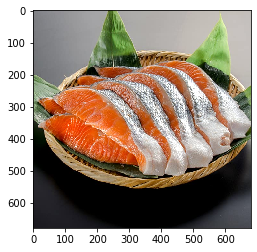

In [10]:
#対象となる画像のファイル名
file_name = base_dir + pic

img = cv2.imread(file_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [11]:
#認証用に発行されたJSONキーの絶対パス
credential_path = base_dir + r'/amplified-cache-277509-4b71fdd784b2.json'

#サービスアカウントキーへのパスを通す
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path

#visionクライアントの初期化
client = vision.ImageAnnotatorClient()

#画像を読み込み
with io.open(file_name, 'rb') as image_file:
    content = image_file.read()
image = types.Image(content=content)

#ラベル検出
response = client.label_detection(image=image)
labels = response.label_annotations

en_label = []

#結果を表示
for label in labels:
        en_label.append(label.description)

print("検出した要素(in English)は以下")
print(en_label)
print( "\n")

検出した要素(in English)は以下
['Dish', 'Cuisine', 'Fish slice', 'Food', 'Sashimi', 'Smoked salmon', 'Kasuzuke', 'Salmon', 'Ingredient', 'Salmon']




In [12]:
def translate_lan(text, tag_language):
    #翻訳先が英語ならそのまま返す
    if tag_language == 'en':
        return text
    translate_client = translate.Client()
    result = translate_client.translate(text, target_language=tag_language)
    return result['translatedText']

In [13]:
ja_label = []
for text in en_label:
    transtext = translate_lan(text, tag_language)
    ja_label.append(transtext)
print("日本語標記は以下")
print(ja_label)
print("\n")

#よく出る食材名以外のものを削除する
exception = ['皿', '調理済み', '食物', '成分', 'ボトル']
for text in exception:
    try:
        ja_label.remove(text)
    except ValueError:
        pass

ja_label_uni = list(set(ja_label))  #重複を削除
print("処理後は以下")
print(ja_label_uni) #消えたか確認
print("\n")

日本語標記は以下
['皿', '調理済み', '魚のスライス', '食物', '刺身', 'スモークサーモン', 'Kasuzuke', 'サーモン', '成分', 'サーモン']


処理後は以下
['Kasuzuke', 'サーモン', '魚のスライス', '刺身', 'スモークサーモン']




In [14]:
year = []
for i in range(1998,2015):
    year.append(i)

for text in ja_label_uni:
    print("・" + text + "を使う料理")
    for i in year:
        print(year[i-1998])
        ingredient = pd.read_csv(f"/Users/tahara_so70/Desktop/Sample/MDA/ingredient/ingredient{i}.csv", names=["ID", "ingredient"], usecols=[0,1])
        #ingredientから指定した素材の行だけ抽出する
        ingredient_in = ingredient[ingredient["ingredient"].isin([text])]
        recipe = pd.read_csv(f"/Users/tahara_so70/Desktop/Sample/MDA/recipe/recipe{i}.csv",names=["ID","title"],usecols=[0,2])
        df = pd.merge(ingredient_in, recipe, on = "ID", how = "left")
        #欠損地を補完
        df["title"] = df["title"].fillna("no-data")
        sug = df.drop('ID', axis=1)
        sug = sug.drop('ingredient', axis=1)
        if sug.empty:
            print("該当レシピは存在しません")
        else:
            print(sug.head(3))
        print("\n")

・Kasuzukeを使う料理
1998
該当レシピは存在しません


1999
該当レシピは存在しません


2000
該当レシピは存在しません


2001
該当レシピは存在しません


2002
該当レシピは存在しません


2003
該当レシピは存在しません


2004
該当レシピは存在しません


2005
該当レシピは存在しません


2006
該当レシピは存在しません


2007
該当レシピは存在しません


2008
該当レシピは存在しません


2009
該当レシピは存在しません


2010
該当レシピは存在しません


2011
該当レシピは存在しません


2012
該当レシピは存在しません


2013
該当レシピは存在しません


2014
該当レシピは存在しません


・サーモンを使う料理
1998
該当レシピは存在しません


1999
該当レシピは存在しません


2000
              title
0          サーモンの酒蒸し
1   サーモンステーキ＊M-Mom風
2  サーモンステーキ・オールドベイ味


2001
                title
0            照り焼きサーモン
1  気分は春！サーモンとキャベツのフライ
2      サーモンクリームソースパスタ


2002
                         title
0                 サーモンを巻いた北あかり
1  簡単すぎるちらし丼です。だけどちょっと豪華なちらし寿司
2          サーモンとアスパラのクリームスパゲティ


2003
                                     title
0                             お客様用　オープンサンド
1  ◆『サーモンのパンプキンマッシュサンド! with野菜のバルサミコソテー添え』
2                             サーモンのカルパッチョ☆


2004
                      title
0        とってもヘルシーお魚サラダどんぶり！
1           鮭と豆腐のオイスターソース炒め
2  ディジョンマスタード